In [1]:
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
u_an = lambda t, r, th: (r**2)*(sin(th)**2)/(7-6*t)

Считаем, что N=200, L=20, M=20:

In [3]:
N = 200
L = 20
M = 20

C = 7
mu = 1

tt = np.linspace(0, 1, N+1)
rr = np.linspace(0, 1, L+1)
thth = np.linspace(0, pi/2, M+1)

tau = np.diff(tt)[0]
hr = np.diff(rr)[0]
hth = np.diff(thth)[0]

In [4]:
def solveTriangleSlae(a, b, c, d):
    n = len(b)
    p, q = np.zeros(n), np.zeros(n)
    c = c + [0]
    p[0] = c[0] / b[0]
    q[0] = d[0] / b[0]
    for i in range(1, n):
        p[i] = c[i] / (b[i] - (a[i - 1] * p[i - 1]))
        q[i] = (d[i] - (a[i - 1] * q[i - 1])) / (b[i] - (a[i - 1]*p[i - 1]))

    x = np.zeros(n)
    m = n - 1

    x[m] = q[-1]
    for i in range(n - 2, -1, -1):
        x[i] = q[i] - (x[i + 1] * p[i])
    return x
    x = np.zeros(n)
    m = n - 1

    x[m] = q[-1]
    for i in range(n - 2, -1, -1):
        x[i] = q[i] - (x[i + 1] * p[i])
    return x

In [5]:
u = np.zeros([N+1, L+1, M+1])

# u[:, L, :] = [[sin(thth[m]) / sqrt(7 - 6*t) for m in range(M+1)] for t in tt]
# u[:, :, M] = [[rr[l] / sqrt(7 - 6*t) for l in range(L+1)] for t in tt]
# u[0, :, :] = [[r*sin(th)/sqrt(7) for th in thth] for r in rr]

u[0] = [[(r**2)*(cos(th)**2)/7 for th in thth] for r in rr]

def step1(n, k, u_prev):
    wavyu = np.zeros([L+1, M+1])
    wavyu[0, :] = np.zeros([M+1])
    wavyu[L, :] = [sin(thth[m])**2 / (7 - 6*tt[n+1]) for m in range(M+1)]
    wavyu[:, 0] = np.zeros([L+1])
    wavyu[:, M] = [rr[l]**2 / (7 - 6*tt[n+1]) for l in range(L+1)]
    for m in range(1, M):
        a = [0] + [- (rr[l] + hr/2) * ((u_prev[l+1][m]) + (u_prev[l][m])) * tau / (2 * rr[l]*(hr**2)) for l in range(1, L)]
        c = [- (rr[l] - hr/2) * ((u_prev[l][m]) + (u_prev[l-1][m])) * tau / (2 * rr[l]*(hr**2)) for l in range(1, L)] + [0]
        b = [1] + [1 - a[l] - c[l-1] for l in range(1, L)] + [1]
        d = [0] + [u[n][l][m] for l in range(1, L)] + [(sin(thth[m])**2)/(7-6*tt[n+1])]

        # A = np.diagflat(a, 1) + np.diagflat(b) + np.diagflat(c, -1)
        # f = np.linalg.solve(A, d)

        f = solveTriangleSlae(c, b, a, d)
        wavyu[:, m] = f
    return wavyu

def step2(n, k, u_prev, wavyu):
    u_curr = np.zeros([L+1, M+1])
    u_curr[0, :] = np.zeros([M+1])
    u_curr[L, :] = [sin(thth[m])**2 / (7 - 6*tt[n+1]) for m in range(M+1)]
    u_curr[:, 0] = np.zeros([L+1])
    u_curr[:, M] = [rr[l]**2 / (7 - 6*tt[n+1]) for l in range(L+1)]
    for l in range(1, L):
        a = [0] + [- (u_prev[l][m+1] + u_prev[l][m]) * tau / (2 * (rr[l]**2)*(hth**2)) for m in range(1, M)]
        c = [-(u_prev[l][m] + u_prev[l][m-1]) * tau / (2 * (rr[l]**2)*(hth**2)) for m in range(1, M)] + [0]
        b = [1] + [1 - a[m] - c[m-1] for m in range(1, M)] + [1]
        d = [0] + [wavyu[l][m] for m in range(1, M)] + [(rr[l]**2)/(7-6*tt[n+1])]

        # A = np.diagflat(a, 1) + np.diagflat(b) + np.diagflat(c, -1)
        # f = np.linalg.solve(A, d)

        f = solveTriangleSlae(c, b, a, d)
        u_curr[l, :] = f
    return u_curr

for n in range(N):
    k = 0
    u_prev = u[n]
    u_curr = u[n]
    while True:
        u_prev, u_curr = u_curr, u_prev
        wavyu = step1(n, k, u_prev)
        u_curr = step2(n, k, u_prev, wavyu)
        if(max([abs( (u_curr[l][m] - u_prev[l][m]) / u_curr[l][m]  ) for l, m in zip(range(1, L), range(1, M))]) < 1e-4):
            break
        k += 1

    u[n+1] = u_curr

In [6]:
d = 0
n = N
d = max([abs(u_an(tt[n], rr[l], thth[m]) - u[n][l][m]) for l, m in zip(range(0, L+1), range(0, M+1))])

d

0.0037763047417528704

In [7]:
nl = (L+1)//10

n = N
m = M//2

u_n = u[n, ::nl, m]
u_an_n = np.array([u_an(tt[n], r, thth[m]) for r in rr[::nl]])

d = abs(u_n - u_an_n)

pd.DataFrame({'r': rr[::nl], 'u': u_n, 'u*': u_an_n, 'd': d}).T

,0,1,2,3,4,5,6,7,8,9,10
r,0.0,0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000,1.0
u,0.0,0.003928,0.017691,0.044038,0.080989,0.127426,0.183234,0.248612,0.323808,0.409033,0.5
u*,0.0,0.005000,0.020000,0.045000,0.080000,0.125000,0.180000,0.245000,0.320000,0.405000,0.5
d,0.0,0.001072,0.002309,0.000962,0.000989,0.002426,0.003234,0.003612,0.003808,0.004033,0.0


In [8]:
nm = (M+1)//10

n = N
l = L//2

u_n = u[n, l, ::nm]
u_an_n = np.array([u_an(tt[n], rr[l], th) for th in thth[::nm]])

d = abs(u_n - u_an_n)

pd.DataFrame({'theta': thth[::nm], 'u': u_n, 'u*': u_an_n, 'd': d}).T

,0,1,2,3,4,5,6,7,8,9,10
theta,0.0,0.157080,0.314159,0.471239,0.628319,0.785398,0.942478,1.099557,1.256637,1.413717,1.570796
u,0.0,0.022595,0.037135,0.059055,0.090269,0.127426,0.165743,0.200679,0.228321,0.245526,0.250000
u*,0.0,0.006118,0.023873,0.051527,0.086373,0.125000,0.163627,0.198473,0.226127,0.243882,0.250000
d,0.0,0.016477,0.013262,0.007528,0.003896,0.002426,0.002116,0.002206,0.002194,0.001644,0.000000


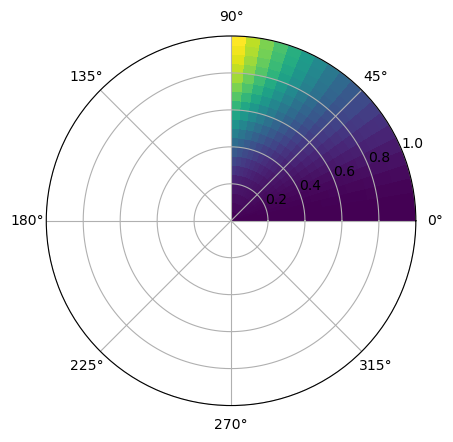

In [9]:
r, th = np.meshgrid(rr, thth)

plt.subplot(projection="polar")

plt.pcolormesh(th, r, u[n])

plt.plot(thth, r, color='k', ls='none') 
plt.grid()

plt.show()